In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
valdir = '/data/stephan/WeatherBench/5.625deg/'

In [5]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z')
t850_valid = load_test_data(f'{valdir}temperature_850', 't')

## Compute preds for 59

In [6]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions//59-resnet_d2_pred_all_6h.nc')

In [7]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, level: 5, lon: 64, time: 17514)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T06:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level    (level) int64 100 250 500 850 1000
Data variables:
    v        (time, lat, lon, level) float64 ...
    u        (time, lat, lon, level) float64 ...
    t        (time, lat, lon, level) float64 ...
    z        (time, lat, lon, level) float64 ...

In [ ]:
print(compute_weighted_rmse(
    preds.z.sel(level=500) if hasattr(preds, 'level') else preds.z, z500_valid
).load())

In [15]:
print(compute_weighted_rmse(
    preds.t.sel(level=850) if hasattr(preds, 'level') else preds.t, t850_valid
).load())

<xarray.DataArray 't_rmse' ()>
array(1.01388284)
Coordinates:
    level    int64 850


## Create iterative predictions

In [7]:
args = load_args('../nn_configs/B/59-resnet_d2_pred_all_6h.yml')

In [8]:
model = tf.keras.models.load_model(
    '/home/rasp/data/myWeatherBench/predictions/saved_models//59-resnet_d2_pred_all_6h.h5',
     custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse}
)

In [9]:
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [10]:
args['test_years'] = ('2017', '2017')

In [11]:
dg = load_data(**args, only_test=True, ext_mean=mean, ext_std=std)

DG start 15:47:51.224804
DG normalize 15:47:51.240650
DG load 15:47:51.252810
Loading data into RAM
DG done 15:50:49.717127


In [12]:
o = dg.output_idxs

In [13]:
a = np.arange(len(dg.data.level))

In [14]:
const_idxs = np.array([i for i in a if i not in o]); const_idxs

array([20, 21, 22])

In [15]:
dg.init_time

<xarray.DataArray 'time' (time: 8754)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ..., '2017-12-31T15:00:00.000000000',
       '2017-12-31T16:00:00.000000000', '2017-12-31T17:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-12-31T17:00:00
Attributes:
    long_name:  time

In [16]:
max_lead_time = 120

In [29]:
state = dg.data[:dg.n_samples][:100].values
consts = state[..., const_idxs]
preds = []
for i in tqdm(range(max_lead_time // dg.lead_time)):
    print(i)
    p = model.predict(state, batch_size=64)
    state = np.concatenate([p, consts], axis=-1)
    p = p * dg.std.isel(level=dg.output_idxs).values + dg.mean.isel(level=dg.output_idxs).values
    preds.append(p)
preds = np.array(preds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



In [30]:
preds.shape

(20, 100, 32, 64, 20)

In [31]:
lead_time = np.arange(dg.lead_time, max_lead_time + dg.lead_time, dg.lead_time)

In [32]:
preds = xr.DataArray(
    preds,
    dims=['lead_time', 'time', 'lat', 'lon', 'level'],
    coords={'lead_time': lead_time, 'time': dg.init_time[:100], 'lat': dg.data.lat, 'lon': dg.data.lon,
            'level': dg.data.isel(level=dg.output_idxs).level,
            'level_names': dg.data.isel(level=dg.output_idxs).level_names
            },
)

In [36]:
unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

In [38]:
das = []
for v in unique_vars:
    idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
    da = preds.isel(level=idxs).squeeze().drop('level_names')
    if not 'level' in da.dims: da = da.drop('level')
    das.append({v: da})

In [39]:
preds = xr.merge(das)

In [40]:
preds

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, level: 5, lon: 64, time: 100)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-01-05T03:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level      (level) int64 100 250 500 850 1000
Data variables:
    t          (lead_time, time, lat, lon, level) float64 231.7 222.4 ... 261.6
    z          (lead_time, time, lat, lon, level) float64 1.561e+05 ... 1.591e+03
    v          (lead_time, time, lat, lon, level) float64 1.229 ... -4.348
    u          (lead_time, time, lat, lon, level) float64 -4.041 ... -1.375

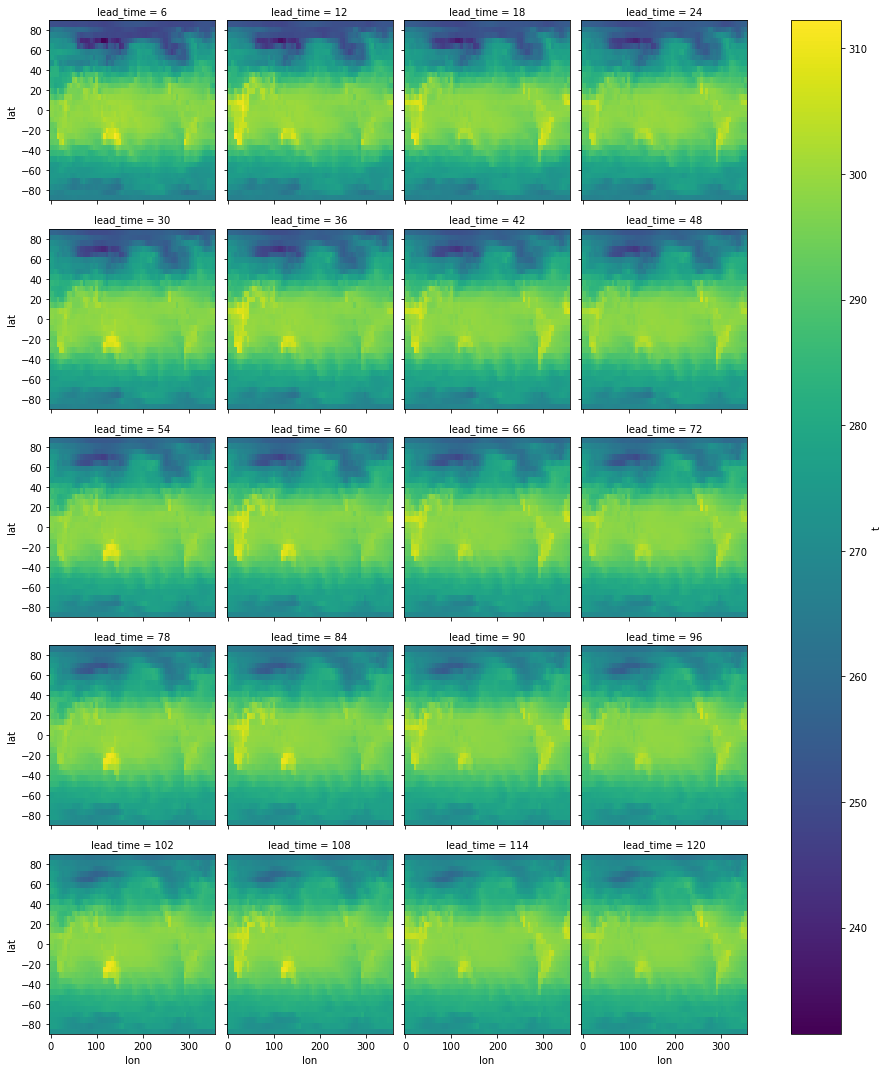

In [43]:
preds.t.isel(lead_time=slice(0, None), time=0).sel(level=1000).plot(col='lead_time', col_wrap=4)

In [48]:
%%time
rmses = evaluate_iterative_forecast(preds.z.sel(level=500), z500_valid).compute()

CPU times: user 710 ms, sys: 393 ms, total: 1.1 s
Wall time: 2min 2s


In [50]:
rmses

<xarray.DataArray 'z_rmse' (lead_time: 20)>
array([ 103.03028427,  177.09084624,  249.37788003,  320.47189694,
        391.11754721,  460.9225216 ,  530.08977622,  599.69454902,
        669.49905941,  738.35677033,  805.62385544,  871.43043515,
        935.64711918,  997.8934026 , 1057.74588478, 1116.27589328,
       1172.80319363, 1227.15554195, 1279.36920544, 1330.40674491])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120

In [51]:
rmses.sel(lead_time=[72, 120])

<xarray.DataArray 'z_rmse' (lead_time: 2)>
array([ 871.43043515, 1330.40674491])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 72 120

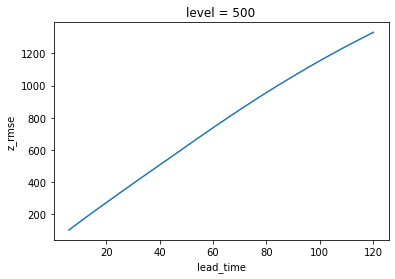

In [49]:
rmses.plot()

In [52]:
%%time
rmses = evaluate_iterative_forecast(preds.t.sel(level=850), t850_valid).compute()

CPU times: user 499 ms, sys: 220 ms, total: 718 ms
Wall time: 55.7 s


In [53]:
rmses

<xarray.DataArray 't_rmse' (lead_time: 20)>
array([1.02253344, 1.33127294, 1.5689402 , 1.80561354, 2.055357  ,
       2.30533049, 2.55537707, 2.81025284, 3.06943303, 3.32883618,
       3.58331626, 3.83578047, 4.08955919, 4.33792276, 4.5849022 ,
       4.82650541, 5.06886195, 5.30210912, 5.52905333, 5.74506283])
Coordinates:
    level      int64 850
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120

In [54]:
rmses.sel(lead_time=[72, 120])

<xarray.DataArray 't_rmse' (lead_time: 2)>
array([3.83578047, 5.74506283])
Coordinates:
    level      int64 850
  * lead_time  (lead_time) int64 72 120

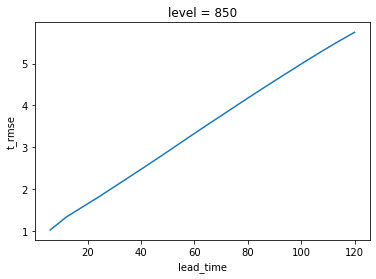

In [55]:
rmses.plot()

## Create iterative predictions, nt=2

In [6]:
args = load_args('../nn_configs/B/62-resnet_d2_pred_all_6h_nt2.yml')

In [7]:
model = tf.keras.models.load_model(
    '/home/rasp/data/myWeatherBench/predictions/saved_models//62-resnet_d2_pred_all_6h_nt.h5',
     custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse}
)

In [8]:
mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [14]:
args['test_years'] = ('2017', '2017')
args['ext_mean'] = mean
args['ext_std'] = std

In [15]:
dg = load_data(**args, only_test=True)

DG start 10:50:28.948732
DG normalize 10:50:28.965820
DG load 10:50:28.980633
Loading data into RAM
DG done 10:59:32.016806


In [16]:
o = dg.output_idxs

In [17]:
a = np.arange(len(dg.data.level))

In [18]:
const_idxs = np.array([i for i in a if i not in o]); const_idxs

array([20, 21, 22])

In [19]:
dg.init_time

<xarray.DataArray 'time' (time: 8751)>
array(['2017-01-01T03:00:00.000000000', '2017-01-01T04:00:00.000000000',
       '2017-01-01T05:00:00.000000000', ..., '2017-12-31T15:00:00.000000000',
       '2017-12-31T16:00:00.000000000', '2017-12-31T17:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T03:00:00 ... 2017-12-31T17:00:00
Attributes:
    long_name:  time

In [20]:
max_lead_time = 120

In [22]:
X, y = dg[0]
X.shape, y.shape

((64, 32, 64, 46), (64, 32, 64, 20))

In [23]:
dg.nt_offset

3

In [24]:
dg.batch_size = 100

In [25]:
X, y = dg[0]
X.shape, y.shape

((100, 32, 64, 46), (100, 32, 64, 20))

In [27]:
state = X
state1 = state[..., :20]
state2 = state[..., 23:43]
consts = state[..., const_idxs]

preds = []
for i in tqdm(range(max_lead_time // dg.lead_time)):
    print(i)
    p = model.predict(state, batch_size=64)
    state = np.concatenate([state2, consts, p, consts], axis=-1)
    state2 = p.copy()
    p = p * dg.std.isel(level=dg.output_idxs).values + dg.mean.isel(level=dg.output_idxs).values
    preds.append(p)
preds = np.array(preds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



In [28]:
preds.shape

(20, 100, 32, 64, 20)

In [29]:
lead_time = np.arange(dg.lead_time, max_lead_time + dg.lead_time, dg.lead_time)

In [30]:
preds = xr.DataArray(
    preds,
    dims=['lead_time', 'time', 'lat', 'lon', 'level'],
    coords={'lead_time': lead_time, 'time': dg.init_time[:100], 'lat': dg.data.lat, 'lon': dg.data.lon,
            'level': dg.data.isel(level=dg.output_idxs).level,
            'level_names': dg.data.isel(level=dg.output_idxs).level_names
            },
)

In [31]:
unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

In [32]:
das = []
for v in unique_vars:
    idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] in v]
    da = preds.isel(level=idxs).squeeze().drop('level_names')
    if not 'level' in da.dims: da = da.drop('level')
    das.append({v: da})

In [33]:
preds = xr.merge(das)

In [34]:
preds

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, level: 5, lon: 64, time: 100)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * time       (time) datetime64[ns] 2017-01-01T03:00:00 ... 2017-01-05T06:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level      (level) int64 100 250 500 850 1000
Data variables:
    z          (lead_time, time, lat, lon, level) float64 1.558e+05 ... 1.757e+03
    v          (lead_time, time, lat, lon, level) float64 1.032 ... -4.865
    u          (lead_time, time, lat, lon, level) float64 -5.052 ... 4.418
    t          (lead_time, time, lat, lon, level) float64 232.1 222.9 ... 253.9

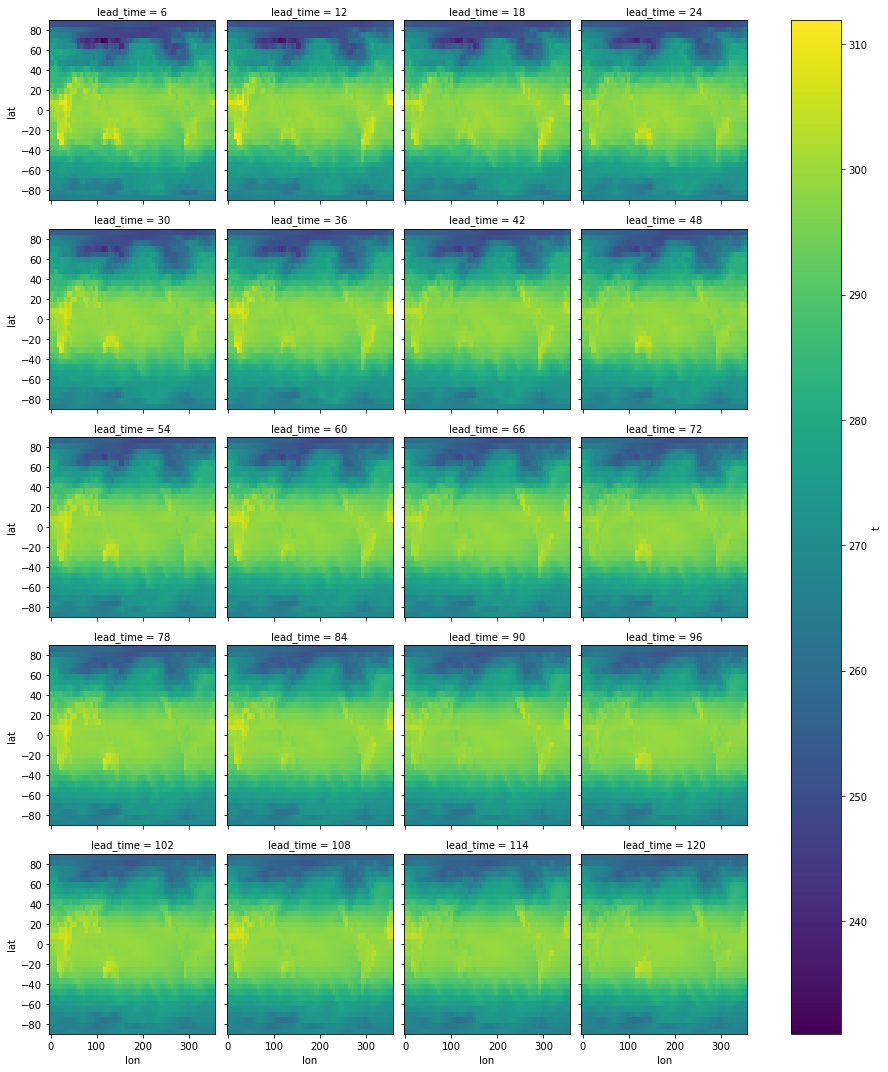

In [35]:
preds.t.isel(lead_time=slice(0, None), time=0).sel(level=1000).plot(col='lead_time', col_wrap=4)

In [36]:
%%time
rmses = evaluate_iterative_forecast(preds.z.sel(level=500), z500_valid).compute()

CPU times: user 368 ms, sys: 136 ms, total: 503 ms
Wall time: 359 ms


In [37]:
rmses

<xarray.DataArray 'z_rmse' (lead_time: 20)>
array([ 129.05406209,  231.49408503,  337.62335942,  434.50970276,
        525.10872375,  606.20369535,  678.73334535,  743.90714634,
        801.74509859,  853.06811785,  898.21125113,  938.35166612,
        973.13956967, 1003.24785617, 1029.90352764, 1053.74291321,
       1074.53435038, 1092.3387465 , 1108.41539776, 1122.64309588])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120

In [38]:
rmses.sel(lead_time=[72, 120])

<xarray.DataArray 'z_rmse' (lead_time: 2)>
array([ 938.35166612, 1122.64309588])
Coordinates:
    level      int64 500
  * lead_time  (lead_time) int64 72 120

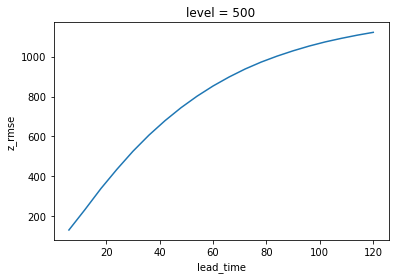

In [39]:
rmses.plot()

In [40]:
%%time
rmses = evaluate_iterative_forecast(preds.t.sel(level=850), t850_valid).compute()

CPU times: user 328 ms, sys: 138 ms, total: 466 ms
Wall time: 332 ms


In [41]:
rmses

<xarray.DataArray 't_rmse' (lead_time: 20)>
array([1.09994944, 1.48831853, 1.82686727, 2.15989325, 2.50382293,
       2.81991781, 3.11191488, 3.3762645 , 3.62218561, 3.84044489,
       4.03638645, 4.21729324, 4.38463483, 4.53634771, 4.67824157,
       4.81047234, 4.93012077, 5.02841426, 5.11504618, 5.19036336])
Coordinates:
    level      int64 850
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120

In [42]:
rmses.sel(lead_time=[72, 120])

<xarray.DataArray 't_rmse' (lead_time: 2)>
array([4.21729324, 5.19036336])
Coordinates:
    level      int64 850
  * lead_time  (lead_time) int64 72 120

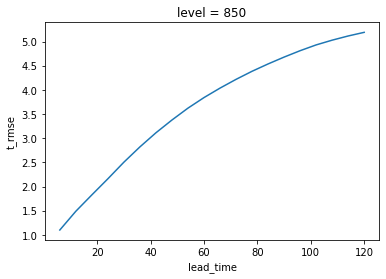

In [43]:
rmses.plot()